In [3]:
import pandas as pd
import numpy as np
import mne
from mne.time_frequency import psd_array_welch
from pymatreader import read_mat
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro
import seaborn as sns
import pylab
import scipy
from itertools import product
from scipy.stats import iqr

In [43]:
import warnings
from mne import create_info
from mne.io import RawArray
from mne.viz.topomap import _add_colorbar
from mne.viz import plot_topomap
from mpl_toolkits.axes_grid1 import make_axes_locatable


import warnings
from mne import create_info
from mne.io import RawArray
from mne.viz.topomap import _add_colorbar
from mne.viz import plot_topomap
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_values_topomap(value_dict, montage, axes, colorbar=True, cmap='GnBu',
                        vmin=None, vmax=None, names=None, image_interp='linear', side_cb="right",
                        sensors=True, show_names=True, format='%2.1e', cbar_title='', **kwargs):
    if names is None:
        names = montage.ch_names

    info = create_info(names, sfreq=256, ch_types="eeg")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        RawArray(np.zeros((len(names), 1)), info, copy=None, verbose=False).set_montage(montage)

    im = plot_topomap([value_dict[ch] for ch in names], pos=info, show=False, image_interp=image_interp,
                      sensors=sensors, res=64, axes=axes, names=None, cmap=cmap, vlim=(vmin,vmax),**kwargs)

    if colorbar:
        try:
            cbar, cax = _add_colorbar(axes, im[0], cmap, pad=.05,
                                      format=format, side=side_cb)
            axes.cbar = cbar
            cbar.ax.tick_params(labelsize=14)
            cax.set_ylabel(cbar_title,fontsize=14)

        except TypeError:
            pass

    return im

In [ ]:
## DATAFRAME CREATION

In [ ]:
ab_ica_pt_selection = pd.read_excel('/Users/lina_01/Desktop/ab_ica/AB_ICA_pt_table.xlsx')

In [ ]:
psd_dfs = []
kinds = ['original', 'AB', 'ICA']
seg_types = ['saccade', 'clean']
path = 'C:/Users/dsrish/Desktop/fieldtrip-20220208'
pts = list(ab_ica_pt_selection['pt'])

for kind in kinds:
    for pt in pts:
        annot_file = f'/Users/dsrish/Desktop/ds_msc_project/manual_annot_AB_ICA_{pt}.csv'
        for seg_type in seg_types:
            annotations = mne.read_annotations(annot_file)
            times = {}
            for annot in annotations:
                times['onset'] = np.array([annot['onset'] for annot in annotations if annot['description']==seg_type])
                times['duration'] = np.array([annot['duration'] for annot in annotations if annot['description']==seg_type])
                times['offset'] = times['onset'] + times['duration']

            crops = []
            for tmin, tmax in zip(times['onset'],times['offset']):
                if kind=='original':
                    raw_file = mne.io.read_raw_fif(f'{path}/{pt}_rest_raw_processed.fif')           

                elif kind=='AB':
                    raw_file_original = mne.io.read_raw_fif(f'{path}/{pt}_rest_raw_processed.fif')
                    AB_mat_outdata = read_mat(f'{path}/{pt}_AB_outdata.mat')
                    AB_mat_outdata = AB_mat_outdata['datatosave_out']['OutData']
                    raw_file = mne.io.RawArray(AB_mat_outdata, raw_file_original.info)

                else:
                    raw_file = mne.io.read_raw_fif(f'{path}/{pt}_rest_raw_ica.fif')
                
                crop = raw_file.crop(tmin=tmin, tmax=tmax)
                crops.append(crop)

            crop_file = mne.concatenate_raws(crops)  

            srate = raw_file.info['sfreq']
            nfft = int(srate/2)
            nperseg = int(0.5*nfft)
            overlap = int(0.25 * nfft)
            psd, freq = psd_welch(crop_file, picks='all', fmin=2, fmax=48, n_fft=nfft, n_per_seg=nperseg, n_overlap=overlap, 
                                  average='mean')
            assert(not np.any(np.isnan(psd)))
            psd = pd.DataFrame(psd)
            psd['pt'] = pt
            psd['channel'] = crop_file.ch_names
            psd['seg_type'] = seg_type
            psd['kind'] = kind
            psd.columns.values[:len(freq)] = freq
            psd_long = pd.melt(psd, id_vars=['pt','channel', 'seg_type', 'kind'], value_vars=list(psd.columns))
            psd_dfs.append(psd_long)

In [ ]:
psd_dfs=pd.concat(psd_dfs)
psd_dfs.rename(columns={'variable':'freq', 'pt':'subject_age','value':'psd'}, inplace=True)

In [ ]:
np.any(np.isnan(psd_dfs.psd))

In [4]:
psd_dfs = pd.read_csv('/Users/lina_01/Desktop/ab_ica/psd_dfs.csv')

psd_dfs['log10_psd'] = np.log(psd_dfs['psd'])

psd_dfs.loc[(psd_dfs['freq']>1.5) & (psd_dfs['freq']<4),'freq_band'] = 'delta'
psd_dfs.loc[(psd_dfs['freq']>3.5) & (psd_dfs['freq']<6),'freq_band'] = 'theta'
psd_dfs.loc[(psd_dfs['freq']>5.5) & (psd_dfs['freq']<9),'freq_band'] = 'low_alpha'
psd_dfs.loc[(psd_dfs['freq']>8.5) & (psd_dfs['freq']<13),'freq_band'] = 'high_alpha'
psd_dfs.loc[(psd_dfs['freq']>12.5) & (psd_dfs['freq']<30),'freq_band'] = 'beta'
psd_dfs.loc[(psd_dfs['freq']>29.5) & (psd_dfs['freq']<50),'freq_band'] = 'gamma'

/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1205/239746940.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'delta' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  psd_dfs.loc[(psd_dfs['freq']>1.5) & (psd_dfs['freq']<4),'freq_band'] = 'delta'


In [ ]:
#Topomap figures

In [5]:
psd_dfs = psd_dfs.groupby(['channel','seg_type','kind','freq_band']).mean(['log10_psd','psd']).reset_index()

In [6]:
montage = mne.channels.make_standard_montage("GSN-HydroCel-129")
channel_names = montage.ch_names

In [7]:
psd_dfs_saccade = psd_dfs.loc[(psd_dfs['seg_type']=='saccade')]
df = psd_dfs_saccade.loc[psd_dfs_saccade['freq_band'] == 'low_alpha']
diffs = np.abs(df.loc[df['kind']=='original']['log10_psd'].values - df.loc[df['kind']=='AB']['log10_psd'].values)

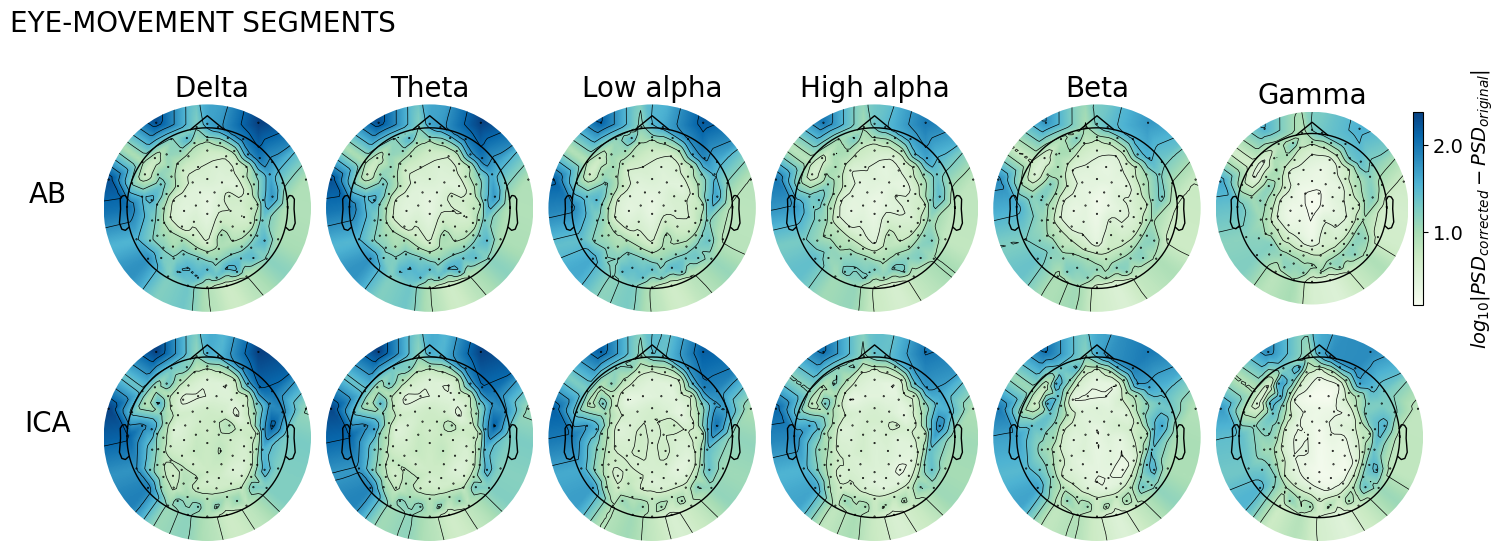

In [44]:
fig, ((ax0,ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10,ax11)) = plt.subplots(2,6,figsize=(15,6))

psd_dfs_saccade = psd_dfs.loc[(psd_dfs['seg_type']=='saccade')]

bands = {'delta':(2,4), 'theta':(4,6), 'low_alpha':(6,9), 'high_alpha':(9,13), 'beta':(13,30), 'gamma':(30,50)}
psd_dfs_subsets = []
for band in list(bands.keys()):
    psd_dfs_saccade_band = psd_dfs_saccade.loc[psd_dfs_saccade['freq_band']==band]
    psd_dfs_subsets.append(psd_dfs_saccade_band)

diffs_list = []
for i in range(len(psd_dfs_subsets)):
    df = psd_dfs_subsets[i]
    diffs = np.abs(df.loc[df['kind']=='original']['log10_psd'].values - df.loc[df['kind']=='AB']['log10_psd'].values)
    diffs_list.append(diffs)

dict_topomaps = []
for i in range(len(diffs_list)):
    channel_array = psd_dfs_subsets[i].channel.unique()
    dict_topomap=dict(zip(channel_array, diffs_list[i]))
    dict_topomaps.append(dict_topomap)

dict_topomaps_reordered = []
for subset in range(len(dict_topomaps)):
    reordered_dict = {}
    for ch in channel_names:
        reordered_dict[ch]=dict_topomaps[subset][ch]
    dict_topomaps_reordered.append(reordered_dict)

vmins = []
vmaxes = []
for i in range(len(dict_topomaps_reordered)):
    vmin = min(dict_topomaps_reordered[i].values())
    vmax = max(dict_topomaps_reordered[i].values())
    vmins.append(vmin)
    vmaxes.append(vmax)

vmin1 = min(vmins)
vmax1 = max(vmaxes)

plot_values_topomap(dict_topomaps_reordered[0], montage, ax0, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
ax0.set_ylabel('AB', labelpad=40, rotation = 'horizontal',fontsize=20, loc='center')
plot_values_topomap(dict_topomaps_reordered[1], montage, ax1, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps_reordered[2], montage, ax2, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps_reordered[3], montage, ax3, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps_reordered[4], montage, ax4, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps_reordered[5], montage, ax5, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=True, cbar_title='$log_{10}|PSD_{corrected}-PSD_{original}|$')

diffs_list = []
for i in range(len(psd_dfs_subsets)):
    df = psd_dfs_subsets[i]
    diffs = np.abs(df.loc[df['kind']=='original']['log10_psd'].values - df.loc[df['kind']=='ICA']['log10_psd'].values)
    diffs_list.append(diffs)

dict_topomaps = []
for i in range(len(diffs_list)):
    channel_array = psd_dfs_subsets[i].channel.unique()
    dict_topomap=dict(zip(channel_array, diffs_list[i]))
    dict_topomaps.append(dict_topomap)

dict_topomaps_reordered = []
for subset in range(len(dict_topomaps)):
    reordered_dict = {}
    for ch in channel_names:
        reordered_dict[ch]=dict_topomaps[subset][ch]
    dict_topomaps_reordered.append(reordered_dict)

vmins = []
vmaxes = []
for i in range(len(dict_topomaps_reordered)):
    vmin = min(dict_topomaps_reordered[i].values())
    vmax = max(dict_topomaps_reordered[i].values())
    vmins.append(vmin)
    vmaxes.append(vmax)

vmin1 = min(vmins)
vmax1 = max(vmaxes)

plot_values_topomap(dict_topomaps[0], montage, ax6, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
ax6.set_ylabel('ICA', labelpad=40, rotation = 'horizontal',fontsize=20, loc='center')
plot_values_topomap(dict_topomaps[1], montage, ax7, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[2], montage, ax8, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[3], montage, ax9, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[4], montage, ax10, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[5], montage, ax11, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)

ax0.set_title('EYE-MOVEMENT SEGMENTS \n \n Delta',fontsize=20)
ax1.set_title('Theta',fontsize=20)
ax2.set_title('Low alpha',fontsize=20)
ax3.set_title('High alpha',fontsize=20)
ax4.set_title('Beta',fontsize=20)
ax5.set_title('Gamma',fontsize=20)

fig.tight_layout()

plt.savefig('fig5a.png', facecolor='white',bbox_inches='tight')

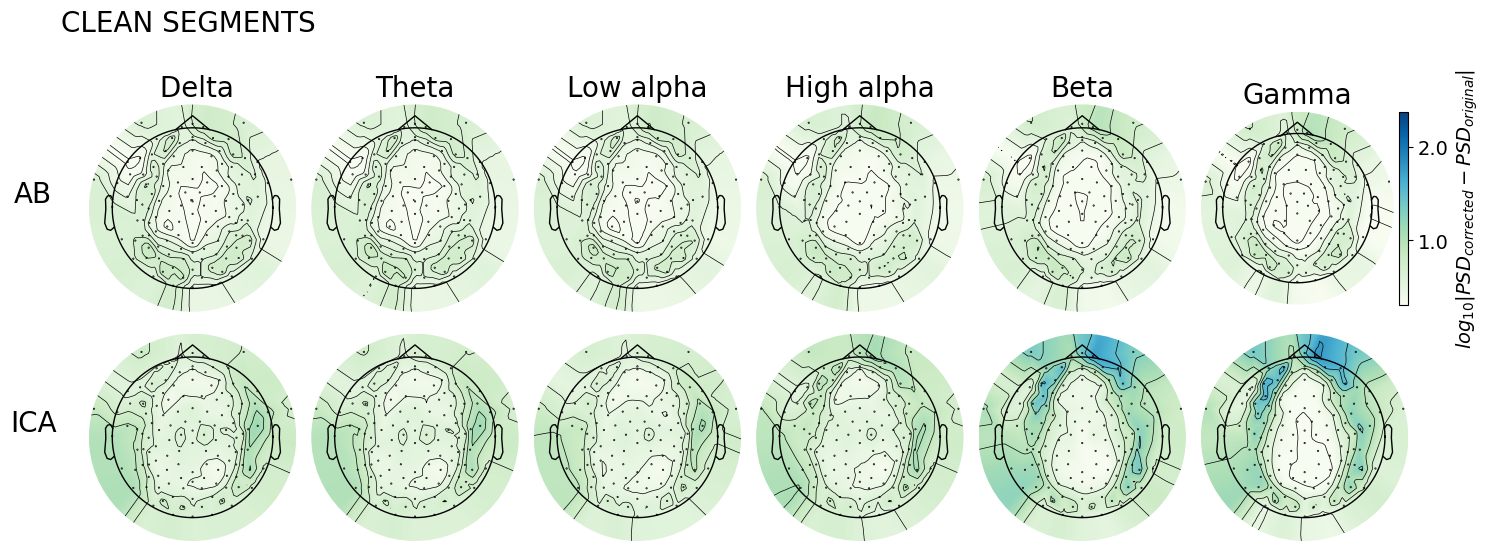

In [45]:
fig, ((ax0,ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10,ax11)) = plt.subplots(2,6,figsize=(15,6))

psd_dfs_clean = psd_dfs.loc[(psd_dfs['seg_type']=='clean')]

bands = {'delta':(2,4), 'theta':(4,6), 'low_alpha':(6,9), 'high_alpha':(9,13), 'beta':(13,30), 'gamma':(30,50)}
psd_dfs_subsets = []
for band in list(bands.keys()):
    psd_dfs_clean_band = psd_dfs_clean.loc[psd_dfs_clean['freq_band']==band]
    psd_dfs_subsets.append(psd_dfs_clean_band)

diffs_list = []
for i in range(len(psd_dfs_subsets)):
    df = psd_dfs_subsets[i]
    diffs = df.loc[df['kind']=='original']['log10_psd'].values - df.loc[df['kind']=='AB']['log10_psd'].values
    diffs_list.append(diffs)

dict_topomaps = []
for i in range(len(diffs_list)):
    channel_array = psd_dfs_subsets[i].channel.unique()
    dict_topomap=dict(zip(channel_array, diffs_list[i]))
    dict_topomaps.append(dict_topomap)

dict_topomaps_reordered = []
for subset in range(len(dict_topomaps)):
    reordered_dict = {}
    for ch in channel_names:
        reordered_dict[ch]=dict_topomaps[subset][ch]
    dict_topomaps_reordered.append(reordered_dict)

plot_values_topomap(dict_topomaps_reordered[0], montage, ax0, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
ax0.set_ylabel('AB', labelpad=40, rotation = 'horizontal',fontsize=20, loc='center')
plot_values_topomap(dict_topomaps_reordered[1], montage, ax1, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps_reordered[2], montage, ax2, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps_reordered[3], montage, ax3, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps_reordered[4], montage, ax4, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps_reordered[5], montage, ax5, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=True, cbar_title='$log_{10}|PSD_{corrected}-PSD_{original}|$')

diffs_list = []
for i in range(len(psd_dfs_subsets)):
    df = psd_dfs_subsets[i]
    diffs = df.loc[df['kind']=='original']['log10_psd'].values - df.loc[df['kind']=='ICA']['log10_psd'].values
    diffs_list.append(diffs)

dict_topomaps = []
for i in range(len(diffs_list)):
    channel_array = psd_dfs_subsets[i].channel.unique()
    dict_topomap=dict(zip(channel_array, diffs_list[i]))
    dict_topomaps.append(dict_topomap)

dict_topomaps_reordered = []
for subset in range(len(dict_topomaps)):
    reordered_dict = {}
    for ch in channel_names:
        reordered_dict[ch]=dict_topomaps[subset][ch]
    dict_topomaps_reordered.append(reordered_dict)

plot_values_topomap(dict_topomaps[0], montage, ax6, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
ax6.set_ylabel('ICA', labelpad=40, rotation = 'horizontal',fontsize=20, loc='center')
plot_values_topomap(dict_topomaps[1], montage, ax7, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[2], montage, ax8, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[3], montage, ax9, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[4], montage, ax10, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[5], montage, ax11, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)

ax0.set_title('CLEAN SEGMENTS \n \n Delta',fontsize=20)
ax1.set_title('Theta',fontsize=20)
ax2.set_title('Low alpha',fontsize=20)
ax3.set_title('High alpha',fontsize=20)
ax4.set_title('Beta',fontsize=20)
ax5.set_title('Gamma',fontsize=20)

fig.tight_layout()

plt.savefig('fig5b.png', facecolor='white',bbox_inches='tight')

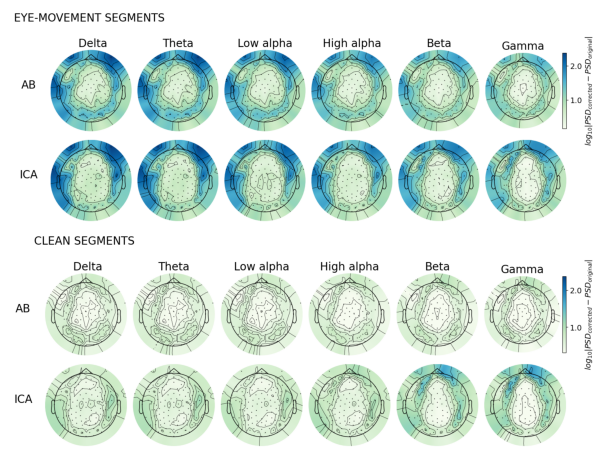

In [46]:
import matplotlib.image as mpimg
figures = ['5a','5b']
margin = 200
fig, axes = plt.subplots(2, 1, figsize=(6, 4.6))
for figure, ax in zip(figures, axes.ravel()):
    img = mpimg.imread(f"/Users/lina_01/Desktop/ab_ica/fig{figure}.png")
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set(frame_on=False)
    
    ax.imshow(img)        
    ax.set_aspect(1)    
    
fig.tight_layout(rect=[-0.01, -0.02, 1.02, 1.02], w_pad=0.0, h_pad=0.0)
fig.savefig("fig5.png", dpi=300)

In [ ]:
#STATISTICAL ANALYSIS

In [22]:
montage = mne.channels.make_standard_montage(kind='GSN-HydroCel-129')
info = mne.create_info(montage.ch_names, sfreq=500, ch_types='eeg')
raw = mne.io.RawArray(np.zeros([129,1]), info).set_montage(montage)

Creating RawArray with float64 data, n_channels=129, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


In [23]:
adj_matrix = mne.channels.find_ch_adjacency(raw.info, ch_type='eeg')[0]
adj_matrix = mne.stats.combine_adjacency(adj_matrix, 6)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 129


In [24]:
threshold = 434

In [25]:
bands = {'delta':(2,4), 'theta':(4,6), 'low_alpha':(6,9), 'high_alpha':(9,13), 'beta':(13,30), 'gamma':(30,50)}

In [26]:
psd_dfs = pd.read_csv('/Users/lina_01/Desktop/ab_ica/psd_dfs.csv')

psd_dfs_saccade = psd_dfs[psd_dfs['seg_type']=='saccade']
psd_dfs_saccade_means = psd_dfs_saccade.groupby(['subject_age', 'channel', 'kind', 'seg_type','freq'])\
                                       .mean().reset_index().drop(columns='Unnamed: 0')
for band_str, band in bands.items():
    psd_dfs_saccade_means.loc[(psd_dfs_saccade_means.freq>=band[0]) & 
                              (psd_dfs_saccade_means.freq<band[1]), 'band'] = band_str

psd_dfs_saccade_means['log10_psd'] = np.log10(psd_dfs_saccade_means['psd'])
psd_dfs_saccade_means = psd_dfs_saccade_means.groupby(['subject_age', 'channel', 'kind', 'seg_type', 'band'])\
                              .mean().reset_index()

original_logs = psd_dfs_saccade_means.loc[psd_dfs_saccade_means['kind']=='original']['log10_psd'].values
ab_logs = psd_dfs_saccade_means.loc[psd_dfs_saccade_means['kind']=='AB']['log10_psd'].values
diff_AB = np.subtract(original_logs, ab_logs)

psd_dfs_saccade_means_ab = psd_dfs_saccade_means.loc[psd_dfs_saccade_means['kind']=='AB']
psd_dfs_saccade_means_ab['diff_AB'] = diff_AB

original_logs = psd_dfs_saccade_means.loc[psd_dfs_saccade_means['kind']=='original']['log10_psd'].values
ica_logs = psd_dfs_saccade_means.loc[psd_dfs_saccade_means['kind']=='ICA']['log10_psd'].values
diff_ICA = np.subtract(original_logs, ica_logs)

psd_dfs_saccade_means_ica = psd_dfs_saccade_means.loc[psd_dfs_saccade_means['kind']=='ICA']
psd_dfs_saccade_means_ica['diff_ICA'] = diff_ICA

/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_823/2403313017.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'delta' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  psd_dfs_saccade_means.loc[(psd_dfs_saccade_means.freq>=band[0]) &
/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_823/2403313017.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psd_dfs_saccade_means_ab['diff_AB'] = diff_AB
/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_823/2403313017.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [27]:
X_saccade_ab_ica = []
for band in bands:
    psd_dfs_saccade_means_bands_ab = psd_dfs_saccade_means_ab.loc[(psd_dfs_saccade_means_ab['band']==band)]
    psd_dfs_saccade_means_bands_ab = psd_dfs_saccade_means_bands_ab[['diff_AB','subject_age','channel']]
    psd_dfs_saccade_means_bands_ab = np.array(psd_dfs_saccade_means_bands_ab.pivot_table(index='subject_age', 
                                                                                       columns='channel', values='diff_AB'))
    
    psd_dfs_saccade_means_bands_ica = psd_dfs_saccade_means_ica.loc[(psd_dfs_saccade_means_ica['band']==band)]
    psd_dfs_saccade_means_bands_ica = psd_dfs_saccade_means_bands_ica[['diff_ICA','subject_age','channel']]
    psd_dfs_saccade_means_bands_ica = np.array(psd_dfs_saccade_means_bands_ica.pivot_table(index='subject_age', 
                                                                                                     columns='channel', 
                                                                                                     values='diff_ICA'))
    X_saccade_ab_ica.append([psd_dfs_saccade_means_bands_ica, psd_dfs_saccade_means_bands_ab])
    
X_saccade_ab_ica = np.array(X_saccade_ab_ica).transpose([1,2,3,0])
    
def wilcox_stat_fun(x, y, axis=0):
    return 1/stats.wilcoxon(x,y,axis=axis)[0]
        
w, clusters, clusters_pv, h0 = mne.stats.permutation_cluster_test(X_saccade_ab_ica, threshold = 1/threshold, n_permutations=1000, 
                                                                  stat_fun=wilcox_stat_fun, adjacency=adj_matrix)

stat_fun(H1): min=0.001570 max=0.007407
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [34]:
set(list(clusters[0][0]))

{0,
 3,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 25,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 38,
 41,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 64,
 65,
 66,
 70,
 75,
 78,
 79,
 82,
 83,
 84,
 89,
 90,
 91,
 92,
 95,
 96,
 97,
 98,
 99,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 111,
 112,
 113,
 117,
 118,
 119,
 120,
 125,
 128}

In [9]:
clusters_pv

array([0.001, 0.491, 0.421])

In [50]:
dfs = []
for i in list(range(len(clusters))):
    clusters_array = np.array(clusters[i])
    df = pd.DataFrame(clusters_array).T
    df['Cluster'] = i
    df = df.rename(columns= {0:'Channel',1:'band'}) 
    dfs.append(df)

In [51]:
heatmap_df = pd.concat(dfs)
heatmap_df = pd.pivot_table(heatmap_df, index='band', columns='Channel', values='Cluster')

<Axes: xlabel='Channel', ylabel='band'>

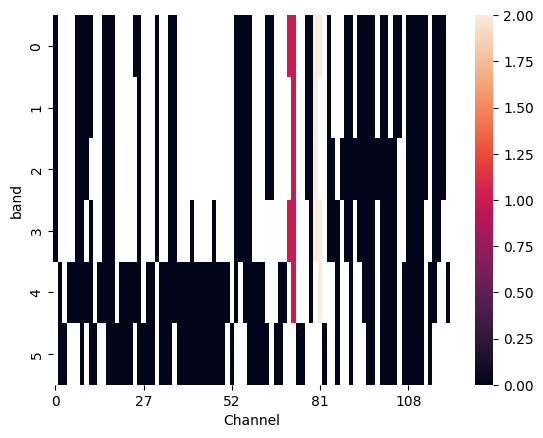

In [52]:
sns.heatmap(heatmap_df,xticklabels=20)

In [35]:
psd_dfs_clean = psd_dfs[psd_dfs['seg_type']=='clean']
psd_dfs_clean_means = psd_dfs_clean.groupby(['subject_age', 'channel', 'kind', 'seg_type','freq'])\
                                       .mean().reset_index().drop(columns='Unnamed: 0')
for band_str, band in bands.items():
    psd_dfs_clean_means.loc[(psd_dfs_clean_means.freq>=band[0]) & 
                              (psd_dfs_clean_means.freq<band[1]), 'band'] = band_str

psd_dfs_clean_means['log10_psd'] = np.log10(psd_dfs_clean_means['psd'])
psd_dfs_clean_means = psd_dfs_clean_means.groupby(['subject_age', 'channel', 'kind', 'seg_type', 'band'])\
                              .mean().reset_index()

original_logs = psd_dfs_clean_means.loc[psd_dfs_clean_means['kind']=='original']['log10_psd'].values
ab_logs = psd_dfs_clean_means.loc[psd_dfs_clean_means['kind']=='AB']['log10_psd'].values
diff_AB = np.abs(np.subtract(original_logs, ab_logs))

psd_dfs_clean_means_ab = psd_dfs_clean_means.loc[psd_dfs_clean_means['kind']=='AB']
psd_dfs_clean_means_ab['diff_AB'] = diff_AB

original_logs = psd_dfs_clean_means.loc[psd_dfs_clean_means['kind']=='original']['log10_psd'].values
ica_logs = psd_dfs_clean_means.loc[psd_dfs_clean_means['kind']=='ICA']['log10_psd'].values
diff_ICA = np.abs(np.subtract(original_logs, ica_logs))

psd_dfs_clean_means_ica = psd_dfs_clean_means.loc[psd_dfs_clean_means['kind']=='ICA']
psd_dfs_clean_means_ica['diff_ICA'] = diff_ICA

/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_823/1103826546.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'delta' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  psd_dfs_clean_means.loc[(psd_dfs_clean_means.freq>=band[0]) &
/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_823/1103826546.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psd_dfs_clean_means_ab['diff_AB'] = diff_AB
/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_823/1103826546.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [36]:
X_clean_ab_ica = []
for band in bands:
    psd_dfs_clean_means_bands_ab = psd_dfs_clean_means_ab.loc[(psd_dfs_clean_means_ab['band']==band)]
    psd_dfs_clean_means_bands_ab = psd_dfs_clean_means_bands_ab[['diff_AB','subject_age','channel']]
    psd_dfs_clean_means_bands_ab = np.array(psd_dfs_clean_means_bands_ab.pivot_table(index='subject_age', 
                                                                                       columns='channel', values='diff_AB'))
    
    psd_dfs_clean_means_bands_ica = psd_dfs_clean_means_ica.loc[(psd_dfs_clean_means_ica['band']==band)]
    psd_dfs_clean_means_bands_ica = psd_dfs_clean_means_bands_ica[['diff_ICA','subject_age','channel']]
    psd_dfs_clean_means_bands_ica = np.array(psd_dfs_clean_means_bands_ica.pivot_table(index='subject_age', 
                                                                                                     columns='channel', 
                                                                                                     values='diff_ICA'))
    X_clean_ab_ica.append([psd_dfs_clean_means_bands_ica, psd_dfs_clean_means_bands_ab])
    
X_clean_ab_ica = np.array(X_clean_ab_ica).transpose([1,2,3,0])
    
def wilcox_stat_fun(x, y, axis=0):
    return 1/stats.wilcoxon(x,y,axis=axis)[0]
        
w, clusters, clusters_pv, h0 = mne.stats.permutation_cluster_test(X_clean_ab_ica, threshold = 1/threshold, n_permutations=1000, 
                                                                  stat_fun=wilcox_stat_fun, adjacency=adj_matrix)

stat_fun(H1): min=0.001572 max=0.011628
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [37]:
clusters_pv

array([0.001, 0.884])

In [41]:
len(set(list(clusters[0][0])))

107